In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from torchsummary import summary
import torch.nn.functional as F

import shutil
from torch import Tensor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from joblib import Parallel, delayed

In [2]:
# data_path = "..\Training Data\MindBigData\MindBigData-Imagenet-IN\MindBigData-Imagenet"
# paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]
# min_samples = 384

# def extract_samples(path):
#     df = pd.read_csv(path, index_col=0, header=None).T
#     return df.shape[0]

# samples = Parallel(n_jobs=-1)(delayed(extract_samples)(path) for path in paths)
# min_number_of_samples = min(samples)
min_number_of_samples = 360

In [4]:
# data_path = "..\Training Data\MindBigData\MindBigData-Imagenet-IN\MindBigData-Imagenet"
# paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]
# X_train, X_test, _, _ = train_test_split(paths, paths, test_size=0.2, shuffle=True)

# for file in os.listdir("..\Training Data\BrainVis_Preprocessing\eegs\\test"):
#     os.remove(os.path.join("..\Training Data\BrainVis_Preprocessing\eegs\\test", file))

# for file in os.listdir("..\Training Data\BrainVis_Preprocessing\eegs\\train"):
#     os.remove(os.path.join("..\Training Data\BrainVis_Preprocessing\eegs\\train", file))

# for path in X_test:
#     example_path = str(path)
#     segments = example_path.split("\\")
#     file_name = segments[-1]
#     shutil.copyfile(path, os.path.join("..\Training Data\BrainVis_Preprocessing\eegs\\test", file_name))
    
# for path in X_train:
#     example_path = str(path)
#     segments = example_path.split("\\")
#     file_name = segments[-1]
#     shutil.copyfile(path, os.path.join("..\Training Data\BrainVis_Preprocessing\eegs\\train", file_name))

In [3]:
class EEG_DataSet(Dataset):
    def __init__(self, eegs_dir, transform=None, target_transform=None):
        self.eegs_dir = eegs_dir
        self.eeg_examples = Parallel(n_jobs=-1)(delayed(EEG_DataSet.extract_sample)(os.path.join(eegs_dir, path)) for path in os.listdir(eegs_dir))
        self.transform = transform
        self.target_transform = target_transform

    @classmethod    
    def extract_sample(cls, sample_path):
        eeg_df = pd.read_csv(sample_path, index_col=0, header=None).T
        eeg_npArray = np.array(eeg_df, dtype=np.float32)[:min_number_of_samples]
        return eeg_npArray

    def __len__(self):
        return len(self.eeg_examples)

    def __getitem__(self, idx):
        eeg_npArray  = self.eeg_examples[idx].T
        eeg_npArray = eeg_npArray[:, :, np.newaxis]
        eeg_tensor = torch.tensor(eeg_npArray, dtype=torch.float32)
        
        if self.transform: eeg_tensor = self.transform(eeg_tensor)
        if self.target_transform: eeg_tensor = self.target_transform(eeg_tensor)
        return eeg_tensor, eeg_tensor

train_dataset = EEG_DataSet("..\Training Data\BrainVis_Preprocessing\eegs\\train",)
test_dataset = EEG_DataSet("..\Training Data\BrainVis_Preprocessing\eegs\\test",)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128)

In [29]:
class Encoder(nn.Module):
    def __init__(self, num_channels, latent_dim):
        super(Encoder, self).__init__()    
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=3, stride=2, padding=1),
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        self.shape_before_flattening = None
        nn.Flatten()
        nn.Linear(64800, latent_dim)
    def forward(self, x):
        x = nn.ReLU(self.conv1(x))
        x = nn.ReLU(self.conv2(x))
        x = nn.ReLU(self.conv3(x))
        self.shape_before_flattening = x.shape[1:]
        x = x.view(x.size(0), -1)
        print("Flattened shape: ", x.shape)
        x = nn.ReLU(x)
        return x

class Decoder(nn.Module):
    def __init__(self, num_channels, channel_size, latent_dim):
        super(Decoder, self).__init__()
        encode_ratio = 32
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64800),
            nn.
            nn.ConvTranspose2d(30, 15, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)),
            nn.ReLU(),
            nn.ConvTranspose2d(15, 5, kernel_size=3, stride=2, padding=(2,1), output_padding=(1, 0)),
            )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

encoder = Encoder(num_channels=5, latent_dim=500).to(device)

# decoder = Decoder(num_channels=5,
#                     channel_size=min_number_of_samples,
#                     latent_dim=500)

criterion = nn.BCELoss()
print("encoder: ", list(encoder.parameters()))
# optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
optimizer = optim.Adam(list(encoder.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2, verbose=True
)



# decoder.to(device)

num_epochs = 50
losses = []
for epoch in range(num_epochs):

    encoder.train()
    # decoder.train()

    batch_loss = []
    for data in train_loader:
        eeg, _ = data
        eeg = eeg.to(device)
        optimizer.zero_grad()

        encoded = encoder(eeg)
        # decoded = decoder(encoded)

        loss = criterion(decoded, eeg)
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())
    losses.append(np.mean(batch_loss))

    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
 
# Save the model
# torch.save(model.state_dict(), 'conv_autoencoder.pth')

cuda
encoder:  []


ValueError: optimizer got an empty parameter list

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, num_channels, channel_size, latent_dim):
        super(Autoencoder, self).__init__()
        encode_ratio = 32
        flattened_size = 5760
        self.encode_conv1 = nn.Conv2d(num_channels, encode_ratio, kernel_size=3, stride=2, padding=1)
        self.encode_conv2 = nn.Conv2d(encode_ratio, encode_ratio*2, kernel_size=3, stride=2, padding=1)
        self.encode_conv3 = nn.Conv2d(encode_ratio*2, encode_ratio*4, kernel_size=3, stride=2, padding=1)
        self.encode_linear = nn.Linear(flattened_size, latent_dim)
        
        self.decode_linear = nn.Linear(latent_dim, flattened_size)
        self.decode_conv1 = nn.ConvTranspose2d(encode_ratio*4, encode_ratio*2, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.decode_conv2 = nn.ConvTranspose2d(encode_ratio*2, encode_ratio, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.decode_conv3 = nn.ConvTranspose2d(encode_ratio, num_channels, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
    def forward(self, x):
        # Encode
        x = F.relu(self.encode_conv1(x))
        x = F.relu(self.encode_conv2(x))
        x = F.relu(self.encode_conv3(x))
        self.shape_before_encode_flattening = x.shape[1:]
        x = x.view(x.size(0), -1)
        x = self.encode_linear(x)

        # Decode
        x = self.decode_linear(x)
        x = x.view(x.size(0), *self.shape_before_encode_flattening)
        x = F.relu(self.decode_conv1(x))
        x = F.relu(self.decode_conv2(x))
        x = F.relu(self.decode_conv3(x))
        return x
    
model = Autoencoder(num_channels=5, channel_size=min_number_of_samples, latent_dim=500)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
losses = []
for epoch in range(num_epochs):
    batch_loss = []
    for data in train_loader:
        eeg, _ = data
        eeg = eeg.to(device)
        optimizer.zero_grad()
        output = model(eeg)
        loss = criterion(output, eeg)
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())
    losses.append(np.mean(batch_loss))

    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
 
# Save the model
torch.save(model.state_dict(), 'conv_autoencoder.pth')

cuda
Epoch [1/50], Loss: 16573.7012
Epoch [6/50], Loss: 6419.7441
Epoch [11/50], Loss: 17565.3633
Epoch [16/50], Loss: 3970.4326
Epoch [21/50], Loss: 7030.0869
Epoch [26/50], Loss: 4682.5679
Epoch [31/50], Loss: 21301.0430
Epoch [36/50], Loss: 3402.5161
Epoch [41/50], Loss: 3347.7317
Epoch [46/50], Loss: 2168.6926


(0.0, 100000.0)

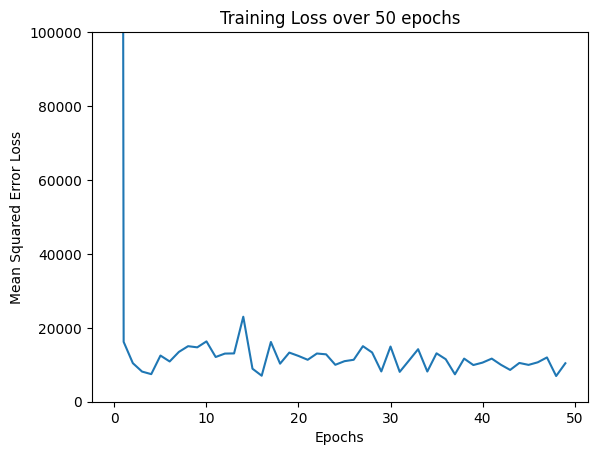

In [5]:
plt.plot(losses)
plt.ylabel("Mean Squared Error Loss")
plt.xlabel("Epochs")
plt.title(f"Training Loss over {num_epochs} epochs")
plt.ylim(0,100000)

In [98]:
test_loss = []
for data in test_loader:
    eeg, _ = data
    eeg = eeg.to(device)
    output = model(eeg)
    loss = criterion(output, eeg)

    test_loss.append(loss.item())

print(f"Average testing loss: {round(np.mean(test_loss), 4)}")

Input shape: torch.Size([128, 5, 360, 1])
Encoder embedding shape: torch.Size([128, 500])
Decoder linear block shape: torch.Size([128, 5760])
Output shape: torch.Size([128, 5, 360, 1])
Input shape: torch.Size([128, 5, 360, 1])
Encoder embedding shape: torch.Size([128, 500])
Decoder linear block shape: torch.Size([128, 5760])
Output shape: torch.Size([128, 5, 360, 1])
Input shape: torch.Size([128, 5, 360, 1])
Encoder embedding shape: torch.Size([128, 500])
Decoder linear block shape: torch.Size([128, 5760])
Output shape: torch.Size([128, 5, 360, 1])
Input shape: torch.Size([128, 5, 360, 1])
Encoder embedding shape: torch.Size([128, 500])
Decoder linear block shape: torch.Size([128, 5760])
Output shape: torch.Size([128, 5, 360, 1])
Input shape: torch.Size([128, 5, 360, 1])
Encoder embedding shape: torch.Size([128, 500])
Decoder linear block shape: torch.Size([128, 5760])
Output shape: torch.Size([128, 5, 360, 1])
Input shape: torch.Size([128, 5, 360, 1])
Encoder embedding shape: torch.Si

Text(0.5, 1.0, 'Sample EEG')

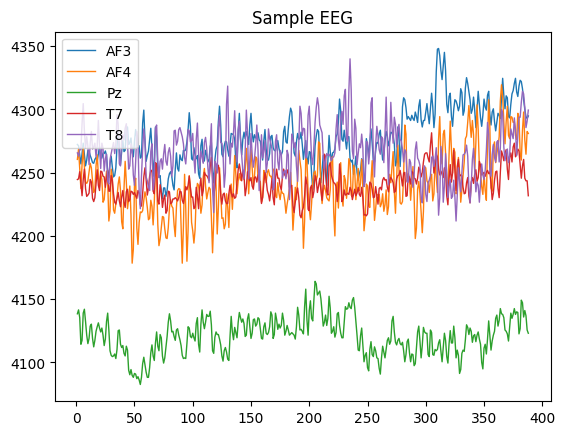

In [55]:
data_path = "..\Training Data\MindBigData\MindBigData-Imagenet-IN\MindBigData-Imagenet"
paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]

df = pd.read_csv(paths[0], index_col=0, header=None).T

for channel in ["AF3", "AF4", "Pz", "T7", "T8"]:
    plt.plot(df[channel], label=channel, linewidth=1)
plt.legend()
plt.title("Sample EEG")

In [91]:
data_path = "..\\Training Data\\MindBigData\\MindBigData-Imagenet-IN\\MindBigData-Imagenet"
paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]

# Read the first CSV file and transpose it
df = pd.read_csv(paths[0], index_col=0, header=None).T

# Define your channel names
channels = ["AF3", "AF4", "Pz", "T7", "T8"]

# Ensure the DataFrame has the correct columns
df = df[channels]

# Limit the number of samples if necessary
df = df.iloc[:min_number_of_samples]

# Process the data as per your existing code
npArray = np.array(df, dtype=np.float32).reshape(len(channels), min_number_of_samples, 1)
pyTorch_tensor = Tensor(npArray).unsqueeze(0).to(device)
print(pyTorch_tensor.shape)
model.eval()
output = model(pyTorch_tensor).squeeze(0)
output.shape

summary(model, (5, 360, 1))

torch.Size([1, 5, 360, 1])
Input shape: torch.Size([1, 5, 360, 1])
Encoder embedding shape: torch.Size([1, 500])
Decoder linear block shape: torch.Size([1, 5760])
Output shape: torch.Size([1, 5, 360, 1])
Input shape: torch.Size([2, 5, 360, 1])
Encoder embedding shape: torch.Size([2, 500])
Decoder linear block shape: torch.Size([2, 5760])
Output shape: torch.Size([2, 5, 360, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 180, 1]           1,472
            Conv2d-2            [-1, 64, 90, 1]          18,496
            Conv2d-3           [-1, 128, 45, 1]          73,856
            Linear-4                  [-1, 500]       2,880,500
            Linear-5                 [-1, 5760]       2,885,760
   ConvTranspose2d-6            [-1, 64, 90, 1]          73,792
   ConvTranspose2d-7           [-1, 32, 180, 1]          18,464
   ConvTranspose2d-8            [-1, 5, 36

In [19]:
data_path = "..\Training Data\MindBigData\MindBigData-Imagenet-IN\MindBigData-Imagenet"
paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]
min_samples = 384

def extract_means(path):
    df = pd.read_csv(path, index_col=0, header=None).T
    return df.mean(axis=0)

samples = pd.DataFrame(Parallel(n_jobs=-1)(delayed(extract_means)(path) for path in paths))
average_channel_signals = samples.mean(axis=0)
average_channel_signals.shape

(5,)


(5, 360, 1)


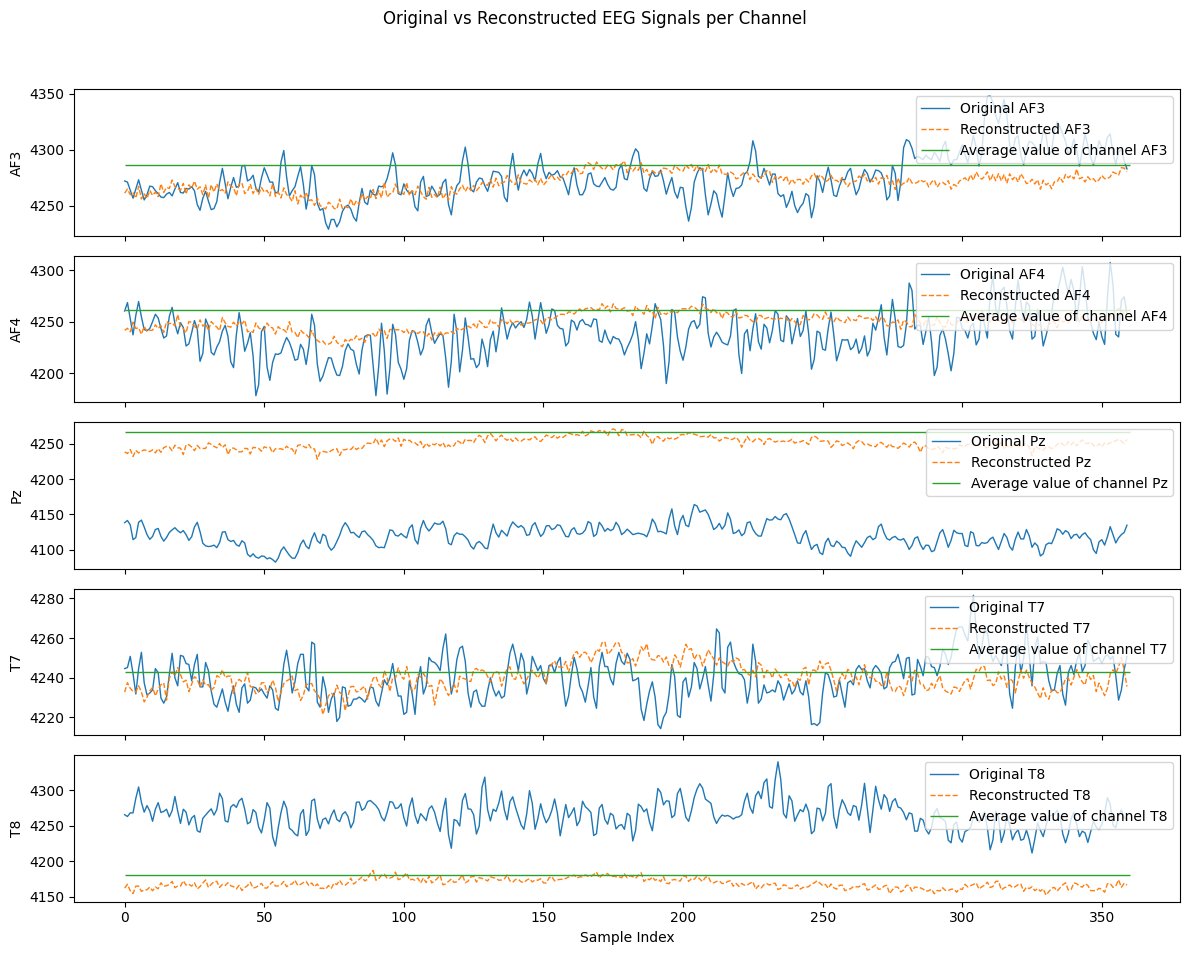

In [23]:
data_path = "..\\Training Data\\MindBigData\\MindBigData-Imagenet-IN\\MindBigData-Imagenet"
paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]

# Read the first CSV file and transpose it
df = pd.read_csv(paths[0], index_col=0, header=None).T


# Define your channel names
channels = ["AF3", "AF4", "Pz", "T7", "T8"]

# Ensure the DataFrame has the correct columns
df = df[channels]

# Limit the number of samples if necessary
df = df.iloc[:min_number_of_samples]

# Process the data as per your existing code
npArray = np.array(df, dtype=np.float32).reshape(len(channels), min_number_of_samples, 1)
pyTorch_tensor = Tensor(npArray).unsqueeze(0).to(device)
output = model(pyTorch_tensor).squeeze(0)

# Get the model's output and reshape appropriately
output_np = output.cpu().detach().numpy()
print(output_np.shape)
# Plot each channel with original and reconstructed signal
fig, axes = plt.subplots(len(channels), 1, figsize=(12, 10), sharex=True)
for idx, channel in enumerate(channels):
    # Plot original signal
    axes[idx].plot(df[channel].values, label=f'Original {channel}', linewidth=1)
    # Plot reconstructed signal
    axes[idx].plot(output_np[idx], label=f'Reconstructed {channel}', linewidth=1, linestyle='--')
    axes[idx].hlines(average_channel_signals[idx], 0, min_number_of_samples, label=f"Average value of channel {channel}", linewidth=1, colors="C2")
    axes[idx].set_ylabel(channel)
    axes[idx].legend(loc='upper right')
axes[-1].set_xlabel('Sample Index')
plt.suptitle('Original vs Reconstructed EEG Signals per Channel')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()